In [1]:
## loading the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
## loading the  data
df=pd.read_csv('cardio_train.csv',sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


## Data Cleaning

In [3]:
## Making age into years as it was given interms of days
df['age']=(df['age']/365).round(2)


In [4]:
## Removing the id column as it will not help in prediction
df.drop('id',axis=1,inplace=True)

In [7]:
## Seprating the numerical and categorical variables
numerical_features=df[['age','height','weight','ap_hi','ap_lo']]
categorical_fetaures=df[['gender','cholesterol','gluc','smoke','alco','active','cardio']]

In [9]:
numerical_features.describe()

,age,height,weight,ap_hi,ap_lo
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,53.339132,164.362217,74.203027,128.829584,96.650092
std,6.759602,8.205337,14.383469,154.775805,189.096240
min,29.580000,55.000000,10.000000,-150.000000,-70.000000
25%,48.390000,159.000000,65.000000,120.000000,80.000000
50%,53.980000,165.000000,72.000000,120.000000,80.000000
75%,58.430000,170.000000,82.000000,140.000000,90.000000
max,64.970000,250.000000,200.000000,16020.000000,11000.000000


## Checking of missing values

In [5]:

df.isnull().sum()
## No missing values in our dataset

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## Removing redundant values

In [ ]:
## While doing eda we have found many such values in age,height,weight,ap_lo,ap_hi are not useful for data
## analysis so we can impute them or drop depending upon the variables

In [5]:
## Step 1 Removing duplicates if any
df.duplicated().sum()

75

In [6]:
## dropping dupliactes
df.drop_duplicates(inplace=True)

In [7]:
## Step 2  Converting height in cms to foot and replacing height above 8foot and less than 3foot
df['height'] = df['height']*0.0328084 
dm =(df['height']>8) | (df['height']<3) 

df.drop(index = list(df[dm].index),inplace=True)
print(f'Dataset: {df.shape}')

Dataset: (69201, 12)


In [8]:
## step 3 Replacing wieghts less 25kg and more than 175kg
# 1. Weight < 25 kg
dm = df['weight']<25
df.drop(index=list(df[dm].index),inplace=True)

# 2. Weight > 175 kg
dm1 = df['weight']>175
dm.drop(index=list(df[dm].index),inplace=True)

# 3. Height < 4.5 & Weight > 150 kg
dm2 = (df['height']<4.5) & (df['weight']>150)
df.drop(index=list(df[dm2].index),inplace=True)

print(f'Dataset: {df.shape}')

Dataset: (69189, 12)


C:\Users\Shubhangi sakarkar\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [9]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,61.56,1,5.085302,69.0,130,80,2,2,0,0,1,0
1,40.13,1,5.347769,71.0,110,70,1,1,0,0,1,1
2,60.00,1,5.413386,70.0,120,80,1,1,0,0,1,0
3,39.86,2,5.413386,85.0,120,80,1,1,1,1,1,0
4,64.09,1,5.085302,62.0,120,80,1,1,0,0,1,0


In [21]:
## step 4 Imputing median value to ap_lo and ap_hi for redundant data
# 1. ap_hi 90mmHg to 180mmHg
median_hi=df.ap_hi.median()
df.loc[df['ap_hi']<90,'ap_hi']=median_hi
df.loc[df['ap_hi']>180,'ap_hi']=median_hi

# 2. ap_lo 80mmHg to 120mmHG
median_lo=df.ap_lo.median()
df.loc[df['ap_lo']<80,'ap_lo']=median_lo
df.loc[df['ap_lo']>120,'ap_lo']=median_lo

In [22]:
print(f'Dataset: {df.shape}')

Dataset: (69189, 12)


In [23]:
## checking the balance of data
cardio_true_count=len(df.loc[df['cardio']==1])
cardio_false_count=len(df.loc[df['cardio']==0])
cardio_true_count,cardio_false_count
## so the dataset is balanced

(34588, 34601)

In [24]:
## saving the clean data
df.to_csv('final_clean.csv')

## Feature selection

In [25]:
## Dividing the dataset into training and test for best fit
from sklearn.model_selection import train_test_split
X=df.iloc[:,0:11]
y=df.cardio
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
X_train.shape,X_test.shape

((51891, 11), (17298, 11))

In [26]:
## checking if any constant features are there in dataset

constant_features=[feat for feat in X_train.columns if X_train[feat].std() == 0]
len(constant_features)
constant_features_test=[feat for feat in X_test.columns if X_test[feat].std() == 0]
len(constant_features_test)
constant_features,constant_features_test


([], [])

In [27]:
## checking for quasi constant features
## training set

quasi_constant_feat = []
for feature in X_train.columns:

    # find the predominant value
    predominant = (X_train[feature].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate predominant feature
    if predominant > 0.998:
        quasi_constant_feat.append(feature)

len(quasi_constant_feat)

0

In [28]:
## test set

quasi_constant_feat = []
for feature in X_test.columns:

    # find the predominant value
    predominant = (X_test[feature].value_counts() / np.float(
        len(X_test))).sort_values(ascending=False).values[0]

    # evaluate predominant feature
    if predominant > 0.998:
        quasi_constant_feat.append(feature)

len(quasi_constant_feat)

0

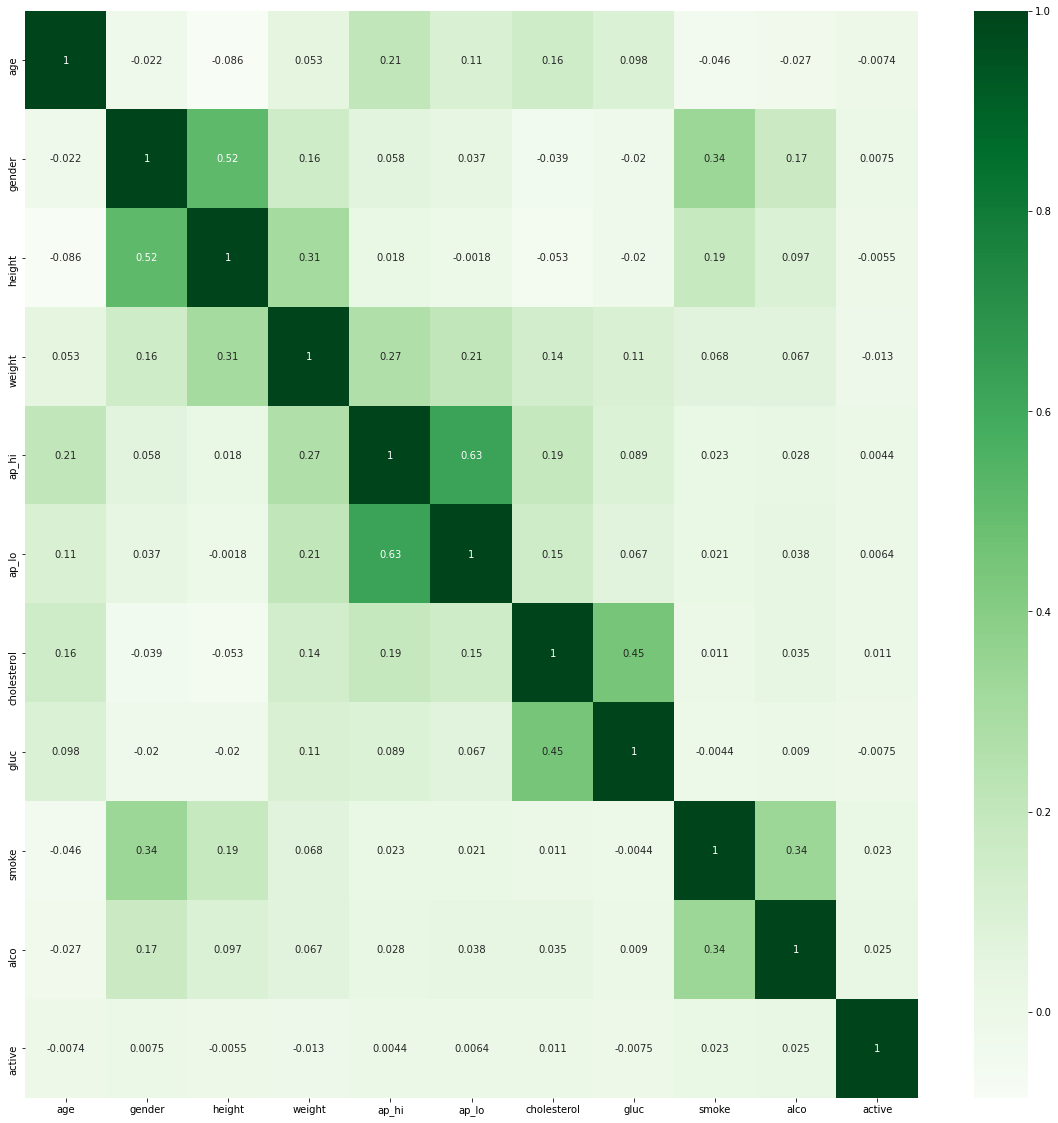

In [30]:
## lets check the correlated features
## Correlation
import seaborn as sns
import matplotlib.pyplot as plt
#get correlations of each features in dataset
corrmat = X_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(X_train[top_corr_features].corr(),annot=True,cmap="Greens")

In [ ]:
## Height and gender shows correlation so we can drop height
## ap_hi and ap_lo shows correlation but both are important so we cannot drop them.
## Similay ways gluco and cholestrol cannot be dropped along with alco and smoke.

In [31]:
## using selectkbest for selecting the features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [32]:
##apply selectkbest class to extract top 10 best features
bestfeatures=SelectKBest(score_func=chi2,k='all')
fit=bestfeatures.fit(X_train,y_train)

In [33]:
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(X_train.columns)

In [34]:
## concatinating 2 df for better visulaization
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['specs','score']

In [35]:
featureScores

,specs,score
0,age,2470.401403
1,gender,0.387167
2,height,0.119094
3,weight,4649.540635
4,ap_hi,20078.954802
5,ap_lo,2586.880600
6,cholesterol,843.791258
7,gluc,110.178744
8,smoke,13.777970
9,alco,3.422698


In [36]:
print(featureScores.nlargest(10,'score'))

          specs         score
4         ap_hi  20078.954802
3        weight   4649.540635
5         ap_lo   2586.880600
0           age   2470.401403
6   cholesterol    843.791258
7          gluc    110.178744
8         smoke     13.777970
10       active     10.695402
9          alco      3.422698
1        gender      0.387167


In [38]:
## using step forward selection
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs1 = SFS(RandomForestClassifier(n_jobs=4), 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

sfs1 = sfs1.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  1.4min finished

[2020-06-09 22:16:20] Features: 1/10 -- score: 0.7500476369870109[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished

[2020-06-09 22:17:51] Features: 2/10 -- score: 0.7688160835326955[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min finished

[2020-06-09 22:19:26] Features: 3/10 -- score: 0.7718374515425539[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [39]:
selected_feat= X_train.columns[list(sfs1.k_feature_idx_)]
selected_feat

Index(['age', 'gender', 'height', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
       'smoke', 'alco', 'active'],
      dtype='object')

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
## checking performance with decisiontree
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier()
DT.fit(X_train[['ap_hi','ap_lo','weight','age','cholesterol','gluc','smoke', 'alco', 'active','gender']],y_train)
y_predict=DT.predict(X_test[['ap_hi','ap_lo','weight','age','cholesterol','gluc','smoke', 'alco', 'active','gender']])
roc=roc_auc_score(y_test,y_predict)
roc

0.6351912952536154

In [ ]:
## so we can go ahead for model creation with tuned parameters

In [46]:
X_train.to_csv('Xtrain.csv')
y_train.to_csv('ytrain.csv')
X_test.to_csv('Xtest.csv')
y_test.to_csv('ytest.csv')